In [241]:
import numpy as np
import numpy.linalg as la
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

Offline Setting

In [242]:

# ====================== DATA & KERNEL ======================
X, true_labels = make_moons(n_samples=50, noise=0.04, random_state=27)
p = X.shape[0]
diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
dist_sq = np.sum(diff ** 2, axis=2)
K = np.exp(-dist_sq / (2 * 0.1))

# ====================== LABELS ======================
# np.random.seed(42)
labeled_cluster0 = np.random.choice(np.where(true_labels == 0)[0], 5, replace=False)
labeled_cluster1 = np.random.choice(np.where(true_labels == 1)[0], 5, replace=False)
labeled_indices = np.concatenate([labeled_cluster0, labeled_cluster1])

eta = np.full(p, 0.5)
eta[labeled_cluster1] = 0.9   # must be in A
eta[labeled_cluster0] = 0.1   # must NOT be in A

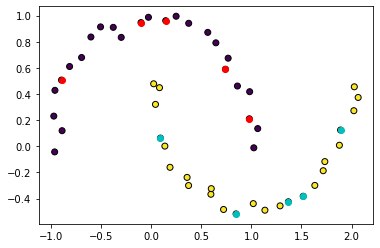

In [243]:
plt.scatter(X[:,0], X[:,1], c=true_labels, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')

Below, we define the cost function and its Lovadz extension with its subgradient. The, we define the ZO-EG algorithm.

In [244]:


# ====================== f(S,y) ======================
def f(A_bin, y, K, eta, labeled_indices):
    A_indices = np.where(A_bin == 1)[0]
    B_indices = np.where(A_bin == 0)[0]
    if len(A_indices) == 0 or len(B_indices) == 0:
        I = 0.0
    else:
        K_AA = K[np.ix_(A_indices, A_indices)] + 1e-8*np.eye(len(A_indices))
        K_BB = K[np.ix_(B_indices, B_indices)] + 1e-8*np.eye(len(B_indices))
        K_full = K + 1e-8*np.eye(p)
        log_det_AA = la.slogdet(K_AA)[1]
        log_det_BB = la.slogdet(K_BB)[1]
        log_det_full = la.slogdet(K_full)[1]
        I = 0.5 * (log_det_AA + log_det_BB - log_det_full)

    prior = 0.0
    unlabeled = np.setdiff1d(np.arange(p), labeled_indices)
    for k in unlabeled:
        prior -= np.log(eta[k] + 1e-12) if A_bin[k] else np.log(1 - eta[k] + 1e-12)

    # labeled part: linear in y
    i = 0
    for k in labeled_indices:
        eta_k = eta[k]
        flipped_eta_k = 1 - eta_k
        if A_bin[k]:
            normal = -np.log(eta_k + 1e-12)
            flipped = -np.log(flipped_eta_k + 1e-12)
        else:
            normal = -np.log(1 - eta_k + 1e-12)
            flipped = -np.log(eta_k + 1e-12)
        prior += (1 - y[i]) * normal + y[i] * flipped
        i += 1
    return I + prior

# ====================== LOVÁSZ EXTENSION & SUBGRADIENT ======================
def lovasz_subgradient_fSy(F_fSy, y_fixed, V, w):
    n = len(V)
    order = np.argsort(-w)
    subgrad = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F_fSy(np.zeros(n, dtype=int), y_fixed)
    for i in range(n):
        candidate = V[order[i]]
        Anew = np.concatenate((A, [candidate]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        marginal = F_fSy(A_bin, y_fixed) - Fold
        subgrad[order[i]] = marginal
        A = Anew
        Fold += marginal
    return subgrad

# ====================== PROJECTIONS ======================
def Projx(x):
    return np.clip(x, 0.0, 1.0)

def Projy(y):
    return np.clip(y, 0.0, 1.0)

# ====================== ZO ORACLE FOR y ======================
def g_muy(func, x, y, mu=0.05, Y=10):
    gs = []
    for _ in range(Y):
        u = np.random.randn(len(y))
        f_plus = func(x, y + mu * u)
        f0 = func(x, y)
        g = (f_plus - f0) / mu
        gs.append(g * u)
    return np.mean(gs, axis=0)

# ====================== EXTRAGRADIENT STEPS ======================
def stepx(subg, x_curr, x_prev, y_curr, h):
    grd = subg(x_curr, y_curr)
    return x_prev - h * grd

def stepy(func, y_prev, x_curr, y_curr, h, mu=0.05, Y=10):
    grd = g_muy(func, x_curr, y_curr, mu, Y)
    return y_prev + h * grd

# ====================== MAIN ZO EXTRAGRADIENT SOLVER ======================
def ZO_minimax(func, subg_fSy, x0, y0, N, h=2e-4, mu=0.05, Y=10):
    p, m = len(x0), len(y0)
    x_hist = np.zeros((p, N+1))
    y_hist = np.zeros((m, N+1))
    x_hist[:, 0] = x0.ravel()
    y_hist[:, 0] = y0.ravel()

    for k in range(N):
        # extragradient steps
        x_tilde = Projx(stepx(subg_fSy, x_hist[:, k], x_hist[:, k], y_hist[:, k], h))
        y_tilde = Projy(stepy(func, y_hist[:, k], x_hist[:, k], y_hist[:, k], h, mu, Y))

        x_hist[:, k+1] = Projx(stepx(subg_fSy, x_hist[:, k], x_tilde, y_tilde, h))
        y_hist[:, k+1] = Projy(stepy(func, y_hist[:, k], x_tilde, y_tilde, h, mu, Y))

    return x_hist, y_hist

# ====================== WRAPPERS ======================
V = np.arange(p)
F_fSy = lambda A_bin, y: f(A_bin, y, K, eta, labeled_indices)

# Lovász value for monitoring
def lovasz_value(w, y_fixed):
    order = np.argsort(-w)
    val = 0.0
    A = np.array([], dtype=int)
    Fold = F_fSy(np.zeros(p, dtype=int), y_fixed)
    for i in range(p):
        Anew = np.concatenate((A, [V[order[i]]]))
        A_bin = np.zeros(p, dtype=int)
        A_bin[Anew] = 1
        marginal = F_fSy(A_bin, y_fixed) - Fold
        val += w[order[i]] * marginal
        A = Anew
        Fold += marginal
    return val

# Subgradient wrapper
def subg_wrapper(w, y):
    return lovasz_subgradient_fSy(F_fSy, y, V, w)

# ====================== RUN MINIMAX ======================
N = 1500
h = 1e-3
mu = 1e-3
Y_samples = 1

w0 = np.random.rand(p)
w0[labeled_cluster0] = 0.1
w0[labeled_cluster1] = 0.9
# y0 = np.random.rand(len(labeled_indices))
y0 = np.zeros(len(labeled_indices))

print("Starting robust minimax optimization...")
x_hist, y_hist = ZO_minimax(lovasz_value, subg_wrapper, w0, y0, N, h=h, mu=mu, Y=Y_samples)

# ====================== EXTRACT BEST SOLUTION ======================
objective_history = []
for k in range(N+1):
    obj = lovasz_value(x_hist[:, k], y_hist[:, k])
    objective_history.append(obj)

# best_iter = np.argmin(objective_history)
# w_best = x_hist[:, best_iter]
# y_worst = y_hist[:, best_iter]

w_best = x_hist[:, -1]
y_worst = y_hist[:, -1]

# print(f"\nBest iteration: {best_iter}")
# print(f"Robust objective value: {objective_history[best_iter]:.4f}")
print(f"Robust objective value: {objective_history[-1]:.4f}")

# ====================== ROUNDING ======================
def round_solution_fSy(w, y_fixed):
    order = np.argsort(-w)
    best_val = np.inf
    best_set = None
    A_bin = np.zeros(p, dtype=int)
    for k in range(1, p+1):
        A_bin[:] = 0
        A_bin[order[:k]] = 1
        val = F_fSy(A_bin, y_fixed)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    return best_set, best_val

S_robust, cost_robust = round_solution_fSy(w_best, y_worst)

# ====================== PRINT RESULTS ======================
print(f"\n=== ROBUST SEMI-SUPERVISED CLUSTERING ===")
print(f"Robust cost (with worst-case label flips): {cost_robust:.4f}")
print(f"Number of points in cluster A: {S_robust.sum()}")
print(f"Worst-case flip probabilities (y*): {y_worst.round(5)}")
print(f"True cost (no attack): {f(S_robust, np.zeros(np.shape(y_worst)), K, eta, labeled_indices):.4f}")


Starting robust minimax optimization...
Robust objective value: 0.1877

=== ROBUST SEMI-SUPERVISED CLUSTERING ===
Robust cost (with worst-case label flips): 32.4098
Number of points in cluster A: 1
Worst-case flip probabilities (y*): [0.0000e+00 5.6200e-03 1.9470e-02 2.8720e-02 1.0000e-04 9.9995e-01
 9.9999e-01 1.0000e+00 1.0000e+00 9.9999e-01]
True cost (no attack): 43.2773


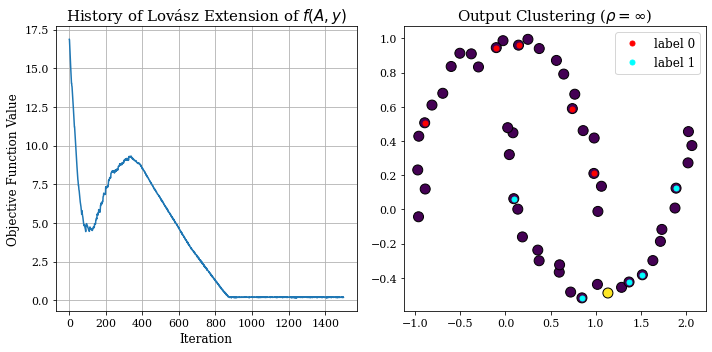

In [245]:
# ====================== VISUALIZATION ======================
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.xlabel('Iteration', fontdict=font1)
plt.ylabel('Objective Function Value', fontdict=font1)
plt.plot(objective_history)
plt.title(f'History of Lovász Extension of $f(A,y)$',fontdict=font)
plt.grid(True)
# plt.legend(loc='best', prop=font1)
plt.subplot(1,2,2)
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.scatter(X[:,0], X[:,1], c=S_robust, edgecolors='k', s=100)
plt.plot(X[labeled_cluster0,0], X[labeled_cluster0,1], 'o', c='red', markersize=5, label='label 0')
plt.plot(X[labeled_cluster1,0], X[labeled_cluster1,1], 'o', c='cyan', markersize=5, label='label 1')
plt.title(f'Output Clustering ($\\rho=\\infty$)',fontdict=font)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
# plt.savefig('trivinf.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [247]:
F_fSy(true_labels, np.zeros(np.shape(y_worst)))

30.701084949578355

In [248]:
A_true_bin = (true_labels == 1).astype(int)
lovasz_value(A_true_bin,np.zeros(np.shape(y_worst)))

-9.064530315943298

In [249]:
# --------------------------------------------------------------
#  TEST: NO ATTACK (y ≡ 0) → should recover the clean clustering
# --------------------------------------------------------------

# 1. Force y to stay at zero
y_fixed = np.zeros(np.shape(y_worst))                     # adversary does nothing
def subg_fixed(w, y):                     # ignore the y argument
    return lovasz_subgradient_fSy(F_fSy, y_fixed, V, w)

N = 1500
h = 1e-3

# 2. Run the same extragradient / ZO solver (y is never updated)
x_hist_noattack, y_hist_noattack = ZO_minimax(
    lovasz_value, subg_fixed, w0, y0, N, h=h, mu=mu, Y=1
)

# 3. Pick the best iterate (w) – y is always zero
obj_noattack = [lovasz_value(x_hist_noattack[:,k], y_fixed) for k in range(N+1)]
best_k = np.argmin(obj_noattack)
w_clean = x_hist_noattack[:, best_k]

# 4. Round to a discrete set (still under y=0)
S_clean, cost_clean = round_solution_fSy(w_clean, y_fixed)

print(f"\n=== CLEAN (NO ATTACK) RESULT ===")
print(f"Cost under y=0 : {cost_clean:.4f}")
print(f"Points in cluster A : {S_clean.sum()}")
print(f"True cost (ground-truth labels) : {f((true_labels==1).astype(int), np.zeros(np.shape(y_fixed)), K, eta, labeled_indices):.4f}")


=== CLEAN (NO ATTACK) RESULT ===
Cost under y=0 : 30.7011
Points in cluster A : 25
True cost (ground-truth labels) : 30.7011


Accuracy under clean labels: 100.00


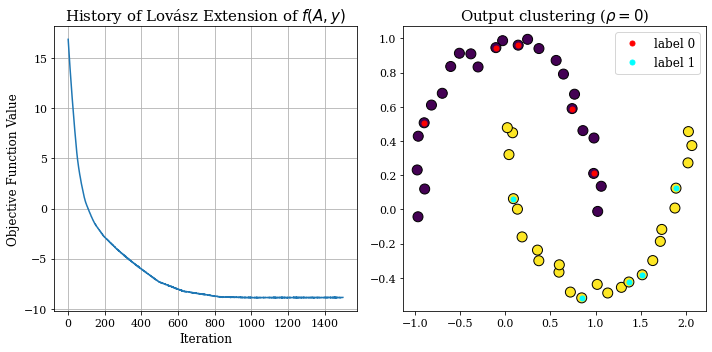

In [250]:
# ====================== VISUALIZATION ======================
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.xlabel('Iteration', fontdict=font1)
plt.ylabel('Objective Function Value', fontdict=font1)
plt.plot(obj_noattack)
plt.title(f'History of Lovász Extension of $f(A,y)$',fontdict=font)
plt.grid(True)
# plt.legend(loc='best', prop=font1)
plt.subplot(1,2,2)
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.scatter(X[:,0], X[:,1], c=S_clean, edgecolors='k', s=100)
plt.plot(X[labeled_cluster0,0], X[labeled_cluster0,1], 'o', c='red', markersize=5, label='label 0')
plt.plot(X[labeled_cluster1,0], X[labeled_cluster1,1], 'o', c='cyan', markersize=5, label='label 1')
plt.title(f'Output clustering ($\\rho=0$)',fontdict=font)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
# plt.savefig('triv0.pdf', dpi=300, transparent=False, bbox_inches='tight')
print(f"Accuracy under clean labels: {(S_clean == true_labels).sum()*100 / p:.2f}")

In [253]:
RHO = 2   # attack budget
N=1500
h = 1e-3
mu = 1e-3
Y_samples = 1
def Projy(y, rho=RHO):
    y = np.clip(y, 0.0, 1.0)
    if y.sum() > rho:
        y = y * (rho / y.sum())  # project onto ℓ1 ball
    return y
# ====================== ROBUST MINIMAX (ℓ1-budgeted y) ======================
print(f"Starting ROBUST minimax with attack budget ρ = {RHO}...")

# Use the *same* ZO oracle on Lovász, but now y is bounded
def g_muy_lovasz(w_fixed, y, mu=0.05, Y=10):
    gs = []
    for _ in range(Y):
        u = np.random.randn(len(y))
        f_plus = lovasz_value(w_fixed, y + mu * u)
        f0 = lovasz_value(w_fixed, y)
        g = (f_plus - f0) / mu
        gs.append(g * u)
    return np.mean(gs, axis=0)

def stepy_lovasz(w_curr, y_prev, y_curr, h, mu=0.05, Y=10):
    grd = g_muy_lovasz(w_curr, y_curr, mu, Y)
    return y_prev + h * grd

def ZO_minimax_robust(x0, y0, N, h=1e-8, mu=1e-8, Y=20, rho=RHO):
    p, m = len(x0), len(y0)
    x_hist = np.zeros((p, N+1))
    y_hist = np.zeros((m, N+1))
    x_hist[:, 0] = x0.copy()
    y_hist[:, 0] = y0.copy()

    for k in range(N):
        x_tilde = Projx(stepx(subg_wrapper, x_hist[:, k], x_hist[:, k], y_hist[:, k], h))
        y_tilde = Projy(stepy_lovasz(x_tilde, y_hist[:, k], y_hist[:, k], h, mu, Y), rho) 
        # second step
        x_hist[:, k+1] = Projx(stepx(subg_wrapper, x_hist[:, k], x_tilde, y_tilde, h))
        y_hist[:, k+1] = Projy(stepy_lovasz(x_tilde, y_hist[:, k], y_tilde, h, mu, Y), rho)

    return x_hist, y_hist

# === RUN IT ===
x_hist, y_hist = ZO_minimax_robust(w0, y0, N, h=h, mu=mu, Y=Y_samples, rho=RHO)

# Evaluate robust objective
objective_history = [lovasz_value(x_hist[:, k], y_hist[:, k]) for k in range(N+1)]
# best_iter = np.argmin(objective_history)
w_best = x_hist[:, -1]
y_worst = y_hist[:, -1]

print(f"Best robust value: {objective_history[-1]:.4f}")
print(f"Worst-case attack (y*): {y_worst.round(3)} (sum = {y_worst.sum():.2f})")


S_robust, cost_robust = round_solution_fSy(w_best, y_worst)
print(f"Accuracy under clean labels: {(S_robust == true_labels).sum()*100 / p:.2f}")

Starting ROBUST minimax with attack budget ρ = 2...
Best robust value: -0.5116
Worst-case attack (y*): [0.082 0.018 0.032 0.021 0.009 0.451 0.344 0.435 0.354 0.254] (sum = 2.00)
Accuracy under clean labels: 100.00



=== ROBUST CLUSTERING (ρ = 2) ===
Cost under worst-case attack: 35.0955
Points in cluster A : 25
Adversary flips 2.0 seeds (y* = [0.08 0.02 0.03 0.02 0.01 0.45 0.34 0.44 0.35 0.25])
Clean cost (y=0): 30.7011
Accuracy under clean labels: 100.00


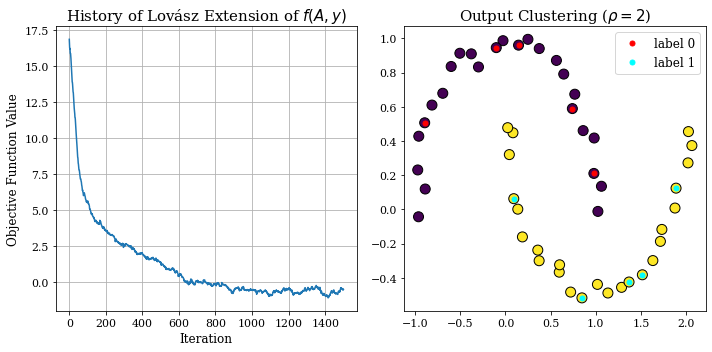

In [254]:
# ====================== VISUALIZATION ======================
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.xlabel('Iteration', fontdict=font1)
plt.ylabel('Objective Function Value', fontdict=font1)
plt.plot(objective_history)
plt.title(f'History of Lovász Extension of $f(A,y)$',fontdict=font)
plt.grid(True)
# plt.legend(loc='best', prop=font1)
plt.subplot(1,2,2)
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.scatter(X[:,0], X[:,1], c=S_robust, edgecolors='k', s=100)
plt.plot(X[labeled_cluster0,0], X[labeled_cluster0,1], 'o', c='red', markersize=5, label='label 0')
plt.plot(X[labeled_cluster1,0], X[labeled_cluster1,1], 'o', c='cyan', markersize=5, label='label 1')
plt.title(f'Output Clustering ($\\rho=2$)',fontdict=font)
plt.legend(loc='best', prop=font1)
plt.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
# plt.savefig('r2.pdf', dpi=300, transparent=False, bbox_inches='tight')


print(f"\n=== ROBUST CLUSTERING (ρ = {RHO}) ===")
print(f"Cost under worst-case attack: {cost_robust:.4f}")
print(f"Points in cluster A : {S_robust.sum()}")
print(f"Adversary flips {y_worst.sum():.1f} seeds (y* = {y_worst.round(2)})")
print(f"Clean cost (y=0): {f(S_robust, np.zeros(np.shape(y_worst)), K, eta, labeled_indices):.4f}")
print(f"Accuracy under clean labels: {(S_robust == true_labels).sum()*100 / p:.2f}")

In [255]:
f_history = [round_solution_fSy(x_hist[:, k], y_hist[:, k])[1] for k in range(N+1)]

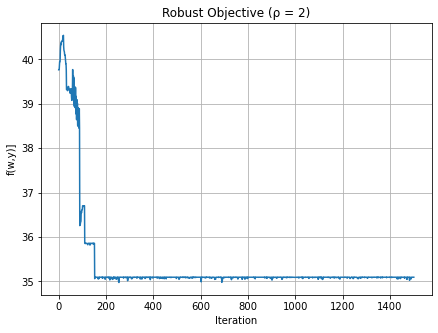

In [256]:
plt.figure(figsize=(7, 5))
plt.plot(f_history)
plt.title(f'Robust Objective (ρ = {RHO})')
plt.xlabel('Iteration')
plt.ylabel('f(w,y)]')
plt.grid(True)

In [257]:
acy=[]
for i in range(1,N,10):
    w_best = x_hist[:, i]
    y_worst = y_hist[:, i]


    S_robust, cost_robust = round_solution_fSy(w_best, y_worst)
    acy.append((S_robust == true_labels).sum()*100/ p)

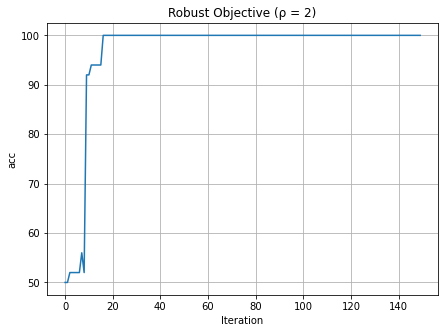

In [260]:
plt.figure(figsize=(7, 5))
plt.plot(acy)
plt.title(f'Robust Objective (ρ = {RHO})')
plt.xlabel('Iteration')
plt.ylabel('acc')
plt.grid(True)

Below, we test the offline problem with different budgets for the attacker.

Starting ROBUST minimax with attack budget ρ = 2.0...
Starting ROBUST minimax with attack budget ρ = 2.15...
Starting ROBUST minimax with attack budget ρ = 2.3...
Starting ROBUST minimax with attack budget ρ = 2.45...
Starting ROBUST minimax with attack budget ρ = 2.6...
Starting ROBUST minimax with attack budget ρ = 2.75...
Starting ROBUST minimax with attack budget ρ = 2.9...
Starting ROBUST minimax with attack budget ρ = 3.05...
Starting ROBUST minimax with attack budget ρ = 3.2...
Starting ROBUST minimax with attack budget ρ = 3.3499999999999996...
Starting ROBUST minimax with attack budget ρ = 3.5...
Starting ROBUST minimax with attack budget ρ = 3.65...
Starting ROBUST minimax with attack budget ρ = 3.8...
Starting ROBUST minimax with attack budget ρ = 3.95...
Starting ROBUST minimax with attack budget ρ = 4.1...
Starting ROBUST minimax with attack budget ρ = 4.25...
Starting ROBUST minimax with attack budget ρ = 4.4...
Starting ROBUST minimax with attack budget ρ = 4.55...
Start

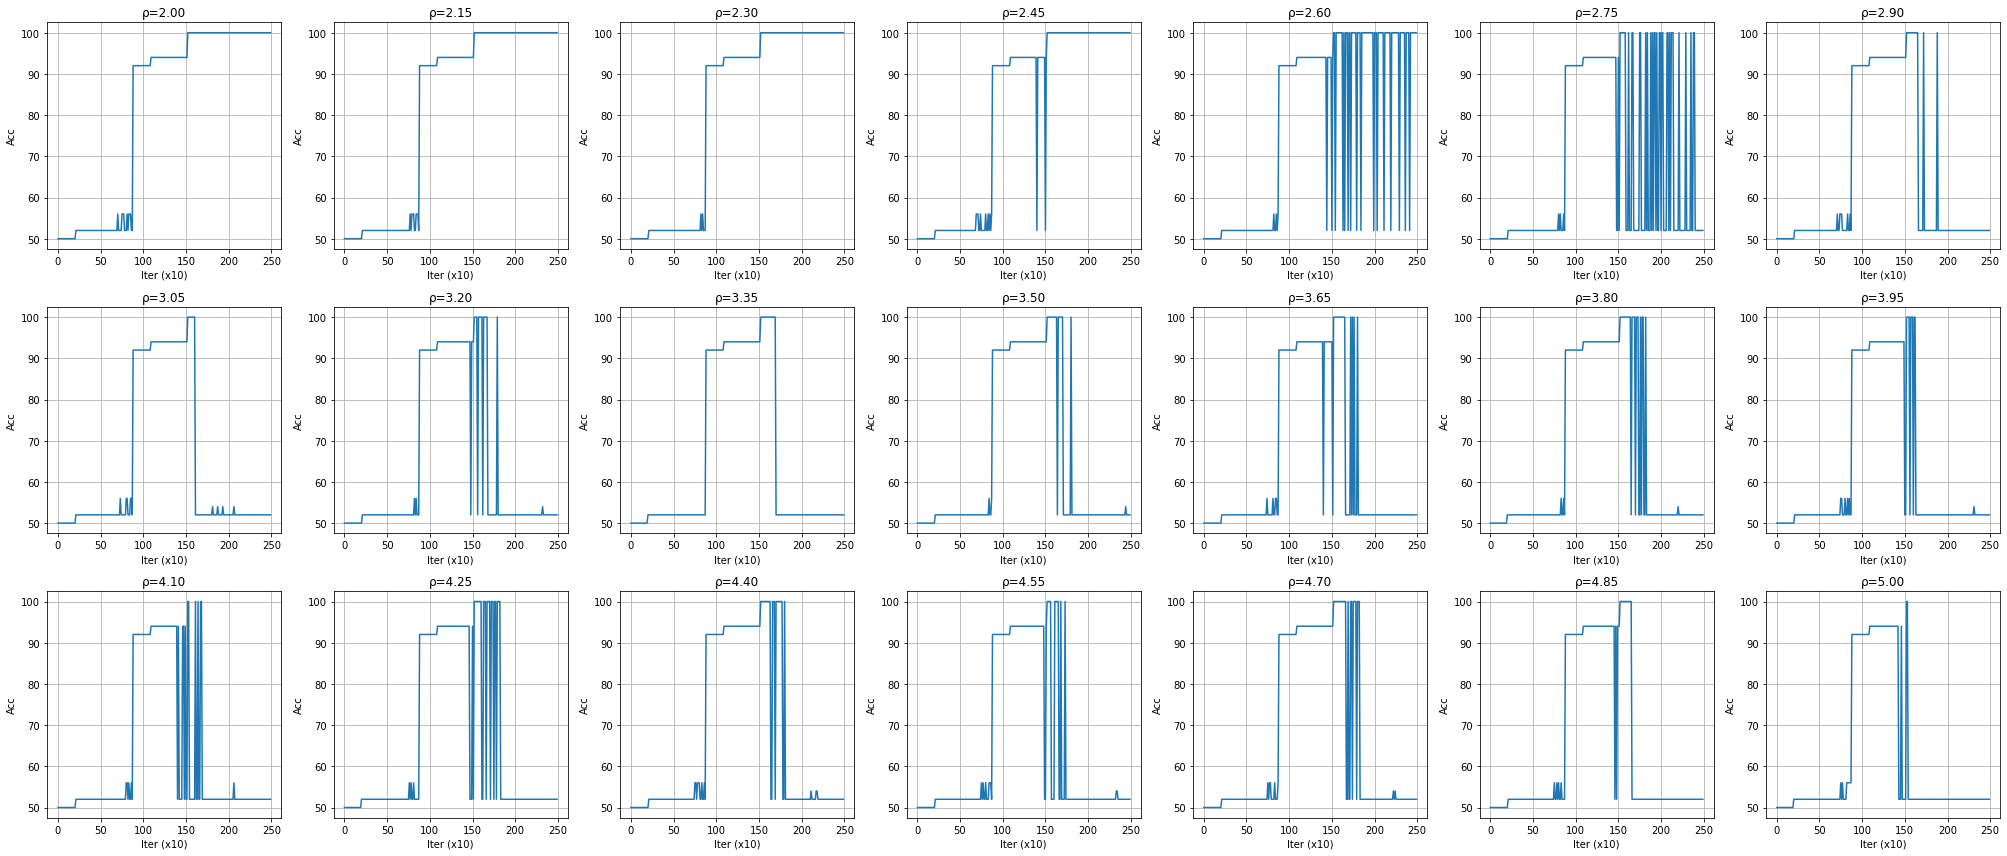

In [264]:
rho_values = np.linspace(2, 5, 21)
accuracies = []
N=2500
h = 1e-4
mu = 1e-6
Y_samples = 1
def Projy(y, rho=1.0):
    y = np.clip(y, 0.0, 1.0)
    if y.sum() > rho:
        y = y * (rho / y.sum())  # project onto ℓ1 ball
    return y
# Use the *same* ZO oracle on Lovász, but now y is bounded
def g_muy_lovasz(w_fixed, y, mu=0.05, Y=1):
    gs = []
    for _ in range(Y):
        u = np.random.randn(len(y))
        f_plus = lovasz_value(w_fixed, y + mu * u)
        f0 = lovasz_value(w_fixed, y)
        g = (f_plus - f0) / mu
        gs.append(g * u)
    return np.mean(gs, axis=0)

def stepy_lovasz(w_curr, y_prev, y_curr, h, mu=0.05, Y=1):
    grd = g_muy_lovasz(w_curr, y_curr, mu, Y)
    return y_prev + h * grd

def ZO_minimax_robust(x0, y0, N, h=1e-5, mu=1e-6, Y=20, rho=1.0):
    p, m = len(x0), len(y0)
    x_hist = np.zeros((p, N+1))
    y_hist = np.zeros((m, N+1))
    x_hist[:, 0] = x0.copy()
    y_hist[:, 0] = y0.copy()

    for k in range(N):
        x_tilde = Projx(stepx(subg_wrapper, x_hist[:, k], x_hist[:, k], y_hist[:, k], h))
        y_tilde = Projy(stepy_lovasz(x_tilde, y_hist[:, k], y_hist[:, k], h, mu, Y), rho) 
        # second step
        x_hist[:, k+1] = Projx(stepx(subg_wrapper, x_hist[:, k], x_tilde, y_tilde, h))
        y_hist[:, k+1] = Projy(stepy_lovasz(x_tilde, y_hist[:, k], y_tilde, h, mu, Y), rho)

    return x_hist, y_hist

fig, axes = plt.subplots(3, 7, figsize=(28, 12))
axes = axes.flatten()
plot_idx = 0
for r in rho_values:
    print(f"Starting ROBUST minimax with attack budget ρ = {r}...")

    # === RUN IT ===
    x_hist, y_hist = ZO_minimax_robust(w0, y0, N, h=h, mu=mu, Y=Y_samples, rho=r)

    # best_iter = np.argmin(objective_history)
    w_best = x_hist[:, -1]
    y_worst = y_hist[:, -1]

    S_robust, cost_robust = round_solution_fSy(w_best, y_worst)
    acc= (S_robust == true_labels).sum()*100 / p
    accuracies.append(acc)
    # print(f"Accuracy: {acc:.2f}")
    acy=[]
    for i in range(1,N,10):
        w_best = x_hist[:, i]
        y_worst = y_hist[:, i]


        S_robust, cost_robust = round_solution_fSy(w_best, y_worst)
        acy.append((S_robust == true_labels).sum()*100/ p)
    ax = axes[plot_idx]
    ax.plot(acy)
    ax.set_title(f"ρ={r:.2f}")
    ax.set_xlabel("Iter (x10)")
    ax.set_ylabel("Acc")
    ax.grid(True)
    plot_idx += 1

plt.tight_layout()
plt.show()

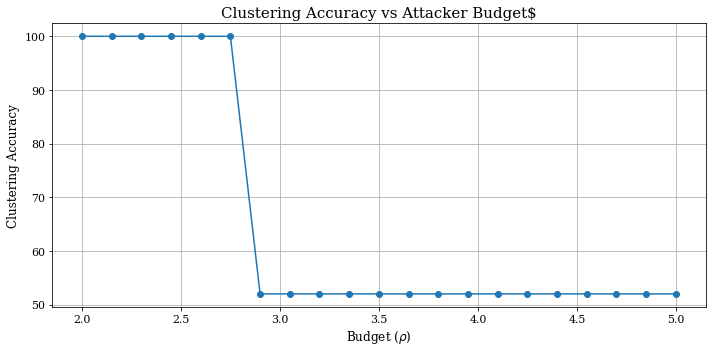

In [265]:
# ====================== VISUALIZATION ======================
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10,5))
plt.xticks(fontname='serif', fontsize=11, color='black')
plt.yticks(fontname='serif', fontsize=11, color='black')
plt.xlabel(f'Budget ($\\rho$)', fontdict=font1)
plt.ylabel('Clustering Accuracy', fontdict=font1)
plt.plot(rho_values, accuracies, marker='o')
plt.title(f'Clustering Accuracy vs Attacker Budget$',fontdict=font)
plt.grid(True)
plt.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('ab.pdf', dpi=300, transparent=False, bbox_inches='tight')


Online Setting

Below we define the trajectories of data points and the corresponding online functions and framework.

In [76]:
import numpy as np
import numpy.linalg as la
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import time


def initialize_moving_moons(n_samples=50, noise=0.04, random_state=27):
    X, true_labels = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    motion_params = {
        0: {'direction': np.array([0.0, 0.7]), 'amplitude': 1.3},
        1: {'direction': np.array([1.5, 0.0]), 'amplitude': 1.1}
    }
    return X, true_labels, motion_params

def update_cluster_positions(X, true_labels, motion_params, iteration, total_iterations):
    X_new = X.copy()
    progress = iteration / total_iterations
    for cluster_id in [0, 1]:
        mask = (true_labels == cluster_id)
        params = motion_params[cluster_id]
        movement = params['direction'] * np.sin(np.pi/2 * progress) * params['amplitude']
        X_new[mask] += movement
    return X_new

def compute_kernel(X, gamma=1/(2*0.1)):
    diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
    dist_sq = np.sum(diff ** 2, axis=-1)
    return np.exp(-gamma * dist_sq)

# ===============================
# OBJECTIVE f(A, y) - SAME AS OFFLINE
# ===============================
def f(A_bin, y, K, eta, labeled_indices):
    A_idx = np.where(A_bin == 1)[0]
    B_idx = np.where(A_bin == 0)[0]
    
    if len(A_idx) == 0 or len(B_idx) == 0:
        I = 0.0
    else:
        K_AA = K[np.ix_(A_idx, A_idx)] + 1e-8*np.eye(len(A_idx))
        K_BB = K[np.ix_(B_idx, B_idx)] + 1e-8*np.eye(len(B_idx))
        K_full = K + 1e-8*np.eye(K.shape[0])
        log_det_AA = la.slogdet(K_AA)[1]
        log_det_BB = la.slogdet(K_BB)[1]
        log_det_full = la.slogdet(K_full)[1]
        I = 0.5 * (log_det_AA + log_det_BB - log_det_full)
    
    prior = 0.0
    unlabeled = np.setdiff1d(np.arange(len(A_bin)), labeled_indices)
    for k in unlabeled:
        prior -= np.log(eta[k] + 1e-12) if A_bin[k] else np.log(1 - eta[k] + 1e-12)
    
    i = 0
    for k in labeled_indices:
        eta_k = eta[k]
        flipped_eta_k = 1 - eta_k
        normal = -np.log(eta_k + 1e-12) if A_bin[k] else -np.log(flipped_eta_k + 1e-12)
        flipped = -np.log(flipped_eta_k + 1e-12) if A_bin[k] else -np.log(eta_k + 1e-12)
        prior += (1 - y[i]) * normal + y[i] * flipped
        i += 1
    return I + prior

# Lovász extension and subgradient
def lovasz_value(F_fSy, w, y_fixed, V):
    order = np.argsort(-w)
    val = 0.0
    A = np.array([], dtype=int)
    Fold = F_fSy(np.zeros(len(V), dtype=int), y_fixed)
    for i in range(len(V)):
        Anew = np.concatenate((A, [V[order[i]]]))
        A_bin = np.zeros(len(V), dtype=int)
        A_bin[Anew] = 1
        marginal = F_fSy(A_bin, y_fixed) - Fold
        val += w[order[i]] * marginal
        A = Anew
        Fold += marginal
    return val

def lovasz_subgradient(F_fSy, w, y_fixed, V):
    n = len(V)
    order = np.argsort(-w)
    subgrad = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F_fSy(np.zeros(n, dtype=int), y_fixed)
    for i in range(n):
        Anew = np.concatenate((A, [V[order[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        marginal = F_fSy(A_bin, y_fixed) - Fold
        subgrad[order[i]] = marginal
        A = Anew
        Fold += marginal
    return subgrad

# ===============================
# PROJECTIONS
# ===============================
def proj_x(x):
    return np.clip(x, 0.0, 1.0)

def proj_y(y, rho=2.0):
    y = np.clip(y, 0.0, 1.0)
    if y.sum() > rho:
        y = y * (rho / y.sum())
    return y

# ===============================
# ZEROTH-ORDER ORACLE FOR y (inner max)
# ===============================
def zo_oracle_y(w_fixed, y, F_fSy_wrapper, mu=0.05, Y=20):
    m = len(y)
    grads = []
    for _ in range(Y):
        u = np.random.randn(m)
        f_plus = F_fSy_wrapper(w_fixed, y + mu * u)
        f0 = F_fSy_wrapper(w_fixed, y)
        g_est = ((f_plus - f0) / mu) * u
        grads.append(g_est)
    return np.mean(grads, axis=0)

# ===============================
# ONLINE MINIMAX (Alternating ZO Updates)
# ===============================
def online_robust_minimax(w0,y0,X0, true_labels, motion_params, 
                         labeled_indices, eta, rho=2.0,
                         N=2000, h=5e-4, mu_y=0.05, Y_samples=20):
    
    p = w0.shape[0]
    m = len(labeled_indices)
    V = np.arange(p)
    
    # Initialize w and y
    w = w0
    y = y0
    
    w_hist = np.zeros((p, N+1))
    y_hist = np.zeros((m, N+1))
    obj_hist = []
    
    w_hist[:, 0] = w.copy()
    y_hist[:, 0] = y.copy()
    
    print("Starting ONLINE robust minimax optimization...")
    start_time = time.time()
    
    for k in range(N):
        if k % 500 == 0:
            print(f"Iteration {k}/{N} | Time: {time.time()-start_time:.1f}s")
        
        # === Update data and kernel at current time step ===
        X_t = update_cluster_positions(X0, true_labels, motion_params, k, N)
        K_t = compute_kernel(X_t)
        
        # Current f(S,y) with current kernel
        F_fSy_current = lambda A_bin, y_val: f(A_bin, y_val, K_t, eta, labeled_indices)
        lovasz_val_current = lambda w_val, y_val: lovasz_value(F_fSy_current, w_val, y_val, V)
        subgrad_w_current = lambda w_val, y_val: lovasz_subgradient(F_fSy_current, w_val, y_val, V)
        
        
        grad_y = zo_oracle_y(w, y, lovasz_val_current, mu=mu_y, Y=Y_samples)
        y_tilde = y + h * grad_y
        y_tilde = proj_y(y_tilde, rho)
        
        grad_w = subgrad_w_current(w, y)
        w_tilde = w - h * grad_w
        w_tilde = proj_x(w_tilde)  
        
        
        grad_y = zo_oracle_y(w_tilde, y_tilde, lovasz_val_current, mu=mu_y, Y=Y_samples)
        y_final = y + h * grad_y
        y_final = proj_y(y_final, rho)
        
        grad_w = subgrad_w_current(w_tilde, y_tilde)
        w_final = w - h * grad_w
        w_final = proj_x(w_final) 
        
        # Update
        w = w_final
        y = y_tilde
        
        w_hist[:, k+1] = w
        y_hist[:, k+1] = y
        
        # Track robust objective
        if k % 1 == 0 or k == N-1:
            robust_val = lovasz_val_current(w, y)
            obj_hist.append(robust_val)
    
    print(f"Finished in {time.time()-start_time:.1f} seconds")
    return w_hist, y_hist, obj_hist

# ===============================
# ROUNDING & EVALUATION
# ===============================
def round_solution_fSy(w, y_worst, K, eta, labeled_indices):
    V = np.arange(len(w))
    F = lambda A_bin: f(A_bin, y_worst, K, eta, labeled_indices)
    order = np.argsort(-w)
    best_val = np.inf
    best_A = None
    A_bin = np.zeros(len(w), dtype=int)
    for i in range(1, len(w)+1):
        A_bin[order[i-1]] = 1
        val = F(A_bin)
        if val < best_val:
            best_val = val
            best_A = A_bin.copy()
    return best_A, best_val

In [72]:
# Data & labels
X_init, true_labels, motion_params = initialize_moving_moons(n_samples=40, noise=0.04, random_state=27)
p = X_init.shape[0]

# Labeled points
labeled_cluster0 = np.random.choice(np.where(true_labels == 0)[0], 4, replace=False)
labeled_cluster1 = np.random.choice(np.where(true_labels == 1)[0], 4, replace=False)
labeled_indices = np.concatenate([labeled_cluster0, labeled_cluster1])

eta = np.full(p, 0.5)
eta[labeled_cluster0] = 0.1   # must NOT be in A
eta[labeled_cluster1] = 0.9   # must be in A

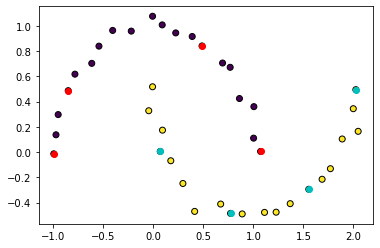

In [73]:
plt.scatter(X_init[:,0], X_init[:,1], c=true_labels, edgecolors="k")
plt.plot(X_init[labeled_cluster0,0],X_init[labeled_cluster0,1],'or')
plt.plot(X_init[labeled_cluster1,0],X_init[labeled_cluster1,1],'oc')

In [95]:
RHO = 2.0
N_iter = 6000
h_step = 1e-4
mu_y = 1e-6
Y_samples = 5
w0 = np.random.rand(p)
w0[labeled_cluster0] = 0.1
w0[labeled_cluster1] = 0.9
# y0 = np.random.rand(len(labeled_indices))
y0 = np.zeros(len(labeled_indices))


w_hist, y_hist, obj_hist = online_robust_minimax(
    w0=w0,
    y0=y0,
    X0=X_init,
    true_labels=true_labels,
    motion_params=motion_params,
    labeled_indices=labeled_indices,
    eta=eta,
    rho=RHO,
    N=N_iter,
    h=h_step,
    mu_y=mu_y,
    Y_samples=Y_samples
)

# Final evaluation on last kernel
X_final = update_cluster_positions(X_init, true_labels, motion_params, N_iter, N_iter)
K_final = compute_kernel(X_final)

w_final = w_hist[:, -1]
y_worst_final = y_hist[:, -1]

S_robust, cost_robust = round_solution_fSy(w_final, y_worst_final, K_final, eta, labeled_indices)
accuracy = np.mean(S_robust == true_labels) * 100

print("\n" + "="*60)
print(f"ONLINE ROBUST MINIMAX RESULT")
print(f"Final robust objective: {obj_hist[-1]:.4f}")
print(f"Worst-case attack cost: {y_worst_final.sum():.3f} (budget = {RHO})")
print(f" accuracy: {accuracy:.2f}%")
print("="*60)

Starting ONLINE robust minimax optimization...
Iteration 0/6000 | Time: 0.0s
Iteration 500/6000 | Time: 61.0s
Iteration 1000/6000 | Time: 122.3s
Iteration 1500/6000 | Time: 183.5s
Iteration 2000/6000 | Time: 244.1s
Iteration 2500/6000 | Time: 304.6s
Iteration 3000/6000 | Time: 365.0s
Iteration 3500/6000 | Time: 425.3s
Iteration 4000/6000 | Time: 485.5s
Iteration 4500/6000 | Time: 547.3s
Iteration 5000/6000 | Time: 609.2s
Iteration 5500/6000 | Time: 670.4s
Finished in 731.4 seconds

ONLINE ROBUST MINIMAX RESULT
Final robust objective: 0.7891
Worst-case attack cost: 2.000 (budget = 2.0)
 accuracy: 100.00%


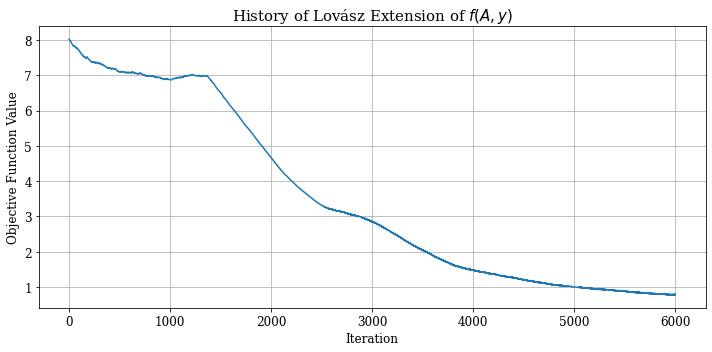

In [99]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10, 5))
plt.xticks(fontname='serif', fontsize=12, color='black')
plt.yticks(fontname='serif', fontsize=12, color='black')
plt.plot(np.arange(0, N_iter, 1), obj_hist, label="Robust Objective (online)")
plt.xlabel("Iteration", fontdict=font1)
plt.ylabel("Objective Function Value", fontdict=font1)
plt.title(f'History of Lovász Extension of $f(A,y)$',fontdict=font)
plt.grid(True)
plt.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('fvalon.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [102]:
K0 = compute_kernel(X_init)
A0, _ = round_solution_fSy(w0, y0, K0, eta, labeled_indices)

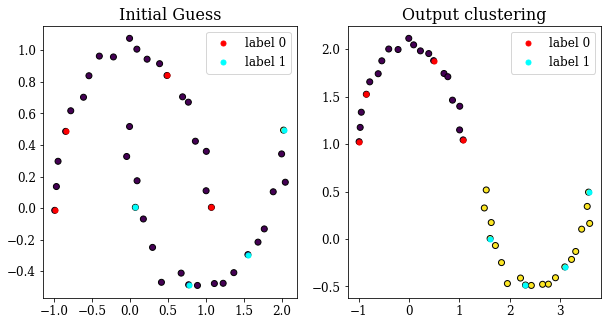

In [104]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
font1 = {'family': 'serif', 'size': 12}
X_final = update_cluster_positions(X_init, true_labels, motion_params, N_iter, N_iter)
        

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=12, color='black')
plt.yticks(fontname='serif', fontsize=12, color='black')
plt.scatter(X_init[:,0], X_init[:,1], c=A0, edgecolors="k")
plt.plot(X_init[labeled_cluster0,0], X_init[labeled_cluster0,1], 'o', c='red', markersize=5, label='label 0')
plt.plot(X_init[labeled_cluster1,0], X_init[labeled_cluster1,1], 'o', c='cyan', markersize=5, label='label 1')
plt.title("Initial Guess",fontdict=font)
plt.legend(loc='best', prop=font1)

plt.subplot(1,2,2)
plt.xticks(fontname='serif', fontsize=12, color='black')
plt.yticks(fontname='serif', fontsize=12, color='black')
plt.scatter(X_final[:,0], X_final[:,1], c=S_robust, edgecolors="k")
plt.plot(X_final[labeled_cluster0,0], X_final[labeled_cluster0,1], 'o', c='red', markersize=5, label='label 0')
plt.plot(X_final[labeled_cluster1,0], X_final[labeled_cluster1,1], 'o', c='cyan', markersize=5, label='label 1')
plt.legend(loc='best', prop=font1)
plt.title("Output clustering",fontdict=font)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('clusteron.pdf', dpi=300, transparent=False, bbox_inches='tight')

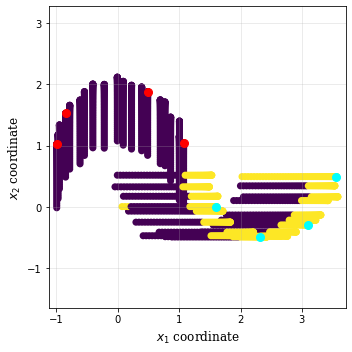

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# ===============================
# SETTINGS - SAME STYLE AS YOUR ORIGINAL CODE
# ===============================
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}
font1 = {'family': 'serif', 'size': 12}

# Choose which iterations to show (feel free to change)
sample_iterations =  np.linspace(0, N_iter, min(50, N_iter), dtype=int)
n_samples = len(sample_iterations)

# Colors for progressive time
colors = plt.cm.viridis(np.linspace(0.1, 0.9, n_samples))

plt.figure(figsize=(5, 5))

for idx, it in enumerate(sample_iterations):
    alpha = 0.15 + 0.85 * (idx / (n_samples - 1))   # from faint to solid
    size = 30 + 70 * (idx / (n_samples - 1))        # from small to large
    
    # Current positions at time `it`
    X_current = update_cluster_positions(X_init, true_labels, motion_params, it, N_iter)
    K_current = compute_kernel(X_current)
    
    # Current robust solution under worst-case attack at this time
    w_it = w_hist[:, it]
    y_it = y_hist[:, it]
    A_bin_it, _ = round_solution_fSy(w_it, y_it, K_current, eta, labeled_indices)
    
    # Plot all points with current robust clustering
    plt.scatter(X_current[:, 0], X_current[:, 1],
                c=A_bin_it,
                alpha=1.0, 
                   s=50,
                   edgecolors='k',
                   linewidth=0.00)

# === Final labeled constraints (plotted on top, always visible) ===
X_final = update_cluster_positions(X_init, true_labels, motion_params, N_iter, N_iter)
plt.plot(X_final[labeled_cluster0,0], X_final[labeled_cluster0,1], 'o', c='red', markersize=8, label='label 0')
plt.plot(X_final[labeled_cluster1,0], X_final[labeled_cluster1,1], 'o', c='cyan', markersize=8, label='label 1')


# === Aesthetics ===
# plt.title('Online Robust Clustering - Postions over Iterations',fontdict=font)
plt.xlabel(f'$x_1$ coordinate', fontdict=font1)
plt.ylabel(f'$x_2$ coordinate', fontdict=font1)
plt.grid(True, alpha=0.3)
plt.axis('equal')


plt.tight_layout()

# Save exactly like your original
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.savefig('online_robust_minimax.pdf', dpi=300, bbox_inches='tight')